# Discretisation of integral equations, parametric version
<i>Author: Mikko Pakkanen</i> (email: mikko.pakkanen@uwaterloo.ca)<br>

This notebook implements a method from:

<i>M. S. Pakkanen, X. Miscouridou, M. J. Penn, C. Whittaker, T. Berah, S. Mishra, T. A. Mellan and S. Bhatt (2022): Unifying incidence and prevalence under a time-varying general branching process. Preprint, https://arxiv.org/abs/2107.05579.</i>

We refer the user of this notebook to the paper for context and any unexplained notation.

The objective of the notebook is to exemplify the discretisation of the integral equation that governs prevalence, $t \mapsto \mathrm{Pr}(t,0)$, under a time-varying <i>Bellman-Harris process</i>, as defined in <b>Example 1</b> of the paper (which is a special case of the more general time-varying <i>Crump-Mode-Jagers process</i> studied in the paper). Extending the vectorised <b>Algorithm 2</b> (introduced in <b>Section 3.1</b> of the paper), this notebook presents a version that has been vectorised also <i>with respect to parameters</i>. Thus, discretisations of $t \mapsto \mathrm{Pr}(t,0)$ are produced simultaneously for a range of parameter values.

Running this notebook requires <code>numpy</code>, <code>scipy</code> and <code>matplotlib</code>, which we import first.

In [1]:
import numpy as np
from scipy.stats import gamma
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In this example, $L^\tau$ follows the Gamma distribution with free shape parameter $a>0$ and $\tau$-dependent scale parameter
$$
\frac{1}{1+0.01\tau}.
$$
The functions <code>G(t, tau, a)</code> and <code>g(t, tau, a)</code> will represent the cumulative distribution function $G^\tau_a(t)$ and probability density function $g^\tau_a(t)$ of $L^\tau$, respectively.
The time-varying effective reproduction number of the Bellman-Harris process will be specified as:
$$
R_b(t) := 1.15 + \sin(bt),
$$
where $b>0$ is a free parameter. In the code, this function will be called <code>R(t, b)</code>. It is worth pointing out that in this example the two parameters left free, $a$ and $b$, have been chosen somewhat haphazardly. We could easily vectorise with respect to other parameters too.

In [2]:
def G(t, tau, a):
    return gamma.cdf(t, a = a, scale = 1 / (1 + 0.01 * tau))

def g(t, tau, a):
    return gamma.pdf(t, a = a, scale = 1 / (1 + 0.01 * tau))

def R(t, b):
    return 1.15 + np.sin(b * t)

We will generate discretisations over $N = 500$ time steps with step size $\Delta = \frac{100}{N}$. We will vary the two free parameters as follows:
$$
a = 3.00, 3.02, 3.04, \ldots, 4.00, \quad b = 0.150,0.151,0.152,\ldots,0.200,
$$
having $51$ (= <code>par_steps</code>) distinct pairs of parameter values.

In [3]:
N = 500
Delta = 100 / N
par_steps = 51
a = np.linspace(start = 3, stop = 4, num = par_steps)
b = np.linspace(start = 0.15, stop = 0.20, num = par_steps)

Discretising the equation for prevalence ($f = \mathrm{Pr}$), we specify $h_a(t,\tau) := 1 - G^{\tau}_a(t-\tau) = \overline{G}^\tau_a(t-\tau)$, via the function <code>h(t, tau, a)</code>.

In [4]:
def h(t, tau, a):
    return 1 - G(t - tau, tau, a)

Working with the Bellman-Harris specification of the model, we set $\lambda^\tau_{a,b}(u) := R_b(u+\tau) g^\tau_a(u)$, via <code>lam(u, tau, a, b)</code>.

In [5]:
def lam(u, tau, a, b):
    return R(u + tau, b) * g(u, tau, a)

The matrix $H$ in <b>Algorithm 2</b> will be superseded by an array <code>H</code> with shape <code>(N + 1, N + 1, par_steps)</code> containing the original $H$ matrix for each pair of parameter values. (Since this needs to be created only once, we do not attempt to optimise the process and simply loop over the parameter values.)

In [6]:
A_H = Delta * np.transpose(np.tile(np.arange(0, N + 1), (N + 1, 1)))
B_H = Delta * toeplitz(np.arange(0, N + 1))
H = np.zeros(shape = (N + 1, N + 1, par_steps))
for j in range(par_steps):
    H[:, :, j] = h(A_H, B_H, a[j])

We similarly create an array <code>L</code> with shape <code>(N, N, par_steps)</code> supplanting the matrix $L$.

In [7]:
A_L = A_H[0 : N, 0 : N]
B_L = Delta * np.tile(np.flip(np.arange(1, N + 1)), (N, 1))
L = np.zeros(shape = (N, N, par_steps))
for j in range(par_steps):
    L[:, :, j] = lam(B_L, A_L, a[j], b[j]) * Delta

The matrix $F$ will be replaced by an array <code>F</code> with shape <code>(N + 1, N + 1, par_steps)</code>, which can be easily initialised using the array <code>H</code>.

In [8]:
F = np.zeros(shape = (N + 1, N + 1, par_steps))
F[:, 0, :] = H[:, 0, :]

Now we are ready to run the for-loop in <b>Algorithm 2</b>. The operations are identical to the standard case except that they are performed on arrays and that the row summation on $B$ is replaced by summation with respect to axis <code>1</code> of the corresponding array <code>B</code>.

In [9]:
for i in range(N):
    B = F[(i + 1) : (N + 1), 0 : (i + 1), :] * L[0 : (N - i), (N - i - 1) : (N + 1), :]
    F[(i + 1) : (N + 1), i + 1, :] = H[(i + 1) : (N + 1), i + 1, :] + np.sum(B, axis = 1)

Once the loop has finished, we extract the diagonal of the slice of <code>F</code> corresponding to each pair of parameter values.

In [10]:
f = np.zeros(shape = (N + 1, par_steps))
for j in range(par_steps):
    f[:, j] = np.diagonal(F[:, :, j])

And, finally, we visualise the results.

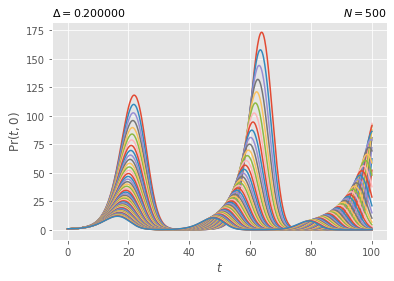

In [11]:
grid = Delta * np.arange(0, N + 1)
for j in range(par_steps):
    plt.plot(grid, f[:, j])
plt.xlabel("$t$")
plt.ylabel("$\mathrm{Pr}(t,0)$")
plt.title(r"$\Delta=$%f" % Delta, loc = "left", fontsize = 11)
plt.title(r"$N=$%i" % N, loc = "right", fontsize = 11)
plt.show()